<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# PCA Lab: Speed Dating

_Authors: Kiefer Katovich (SF)_

---

Let's practice principal component analysis (PCA) using a data set from Kaggle. PCA is often used to simplify data, reduce noise, and find unmeasured latent variables, so it's important to take the time to understand what's going on.

**In this lab, we will:**

- Explore how PCA relates to correlation.
- Use PCA to perform dimensionality reduction.
- Predict whether or not a speed dater likes reading based on the dater's other likes.

---

### Data Set

The data set we're using for this lab is a subset of this [much more detailed speed dating data set](https://www.kaggle.com/annavictoria/speed-dating-experiment). In particular, this contains no information on the actual speed dating itself (i.e., successes with or opinions of other individuals). 

It also contains no follow-up information where individuals are asked the same questions about themselves again. It only contains information about what an individual enjoys doing, their self-ratings on how desirable they are, and how they think others rate them based on desirability.

The columns present in the data are outlined below:

FieldName|Description
---------|-----------
    subject_id                   |   Unique individual identifier.
    wave                         |   Meetup ID.
    like_sports                  |   Enjoyment of participating in sports.
    like_tvsports                |   Enjoyment of watching sports on TV.
    like_exercise                |   Enjoyment of exercise.
    like_food                    |   Enjoyment of food.
    like_museums                 |   Enjoyment of museums.
    like_art                     |   Enjoyment of art.
    like_hiking                  |   Enjoyment of hiking.
    like_gaming                  |   Enjoyment of playing games.
    like_clubbing                |   Enjoyment of going clubbing/partying.
    like_reading                 |   Enjoyment of reading.
    like_tv                      |   Enjoyment of TV in general.
    like_theater                 |   Enjoyment of the theater (plays, musicals, etc.).
    like_movies                  |   Enjoyment of movies.
    like_concerts                |   Enjoyment of concerts.
    like_music                   |   Enjoyment of music.
    like_shopping                |   Enjoyment of shopping.
    like_yoga                    |   Enjoyment of yoga.
    subjective_attractiveness    |   How attractive they rate themselves.
    subjective_sincerity         |   How sincere they rate themselves.
    subjective_intelligence      |   How intelligent they rate themselves.
    subjective_fun               |   How fun they rate themselves.
    subjective_ambition          |   How ambitious they rate themselves.
    objective_attractiveness     |   Perceived rating others would give them on how attractive they are.
    objective_sincerity          |   Perceived rating others would give them on how sincere they are.
    objective_intelligence       |   Perceived rating others would give them on how intelligent they are.
    objective_fun                |   Perceived rating others would give them on how fun they are.
    objective_ambition           |   Perceived rating others would give them on how ambitious they are.
    
There are 551 subjects total.

---

### 1) Load packages.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

%config InlineBackend.figure_format = 'retina'

---

### 2) Load and clean the speed dating data.

- First, remove columns with more than 200 missing values.
- Then, remove rows with missing values.
- Verify that no rows contain NaNs.

In [6]:
sd = pd.read_csv('./datasets/speed_dating.csv')

In [7]:
# sd.isnull().sum()
# objective_attractiveness     237
# objective_sincerity          237
# objective_intelligence       237
# objective_fun                237
# objective_ambition           237

In [8]:
# Remove columns with more than 200 missing values
# Equivalent to keep column with less than or equal 200 missing values
sd = sd.loc[:, sd.isnull().sum() <= 200]

In [9]:
# Drop rows contain NaNs
sd = sd.dropna()

---

### 3) Example: Are the `subjective` columns correlated?

Here, we'll understand how the `subjective` columns are correlated.

- Find the z scores of each `subjective` column (i.e. standardize the `subjective` columns).
- Visualize correlation using [PairGrid](https://seaborn.pydata.org/generated/seaborn.PairGrid.html).
- Visualize correlation using a heat map.

**3.A) Find the z scores of each column. This allows the columns to more easily be directly compared.**

In [12]:
subjective_cols = [col for col in sd.columns \
                   if col.startswith('subjective')]

In [13]:
subjective_cols

['subjective_attractiveness',
 'subjective_sincerity',
 'subjective_intelligence',
 'subjective_fun',
 'subjective_ambition']

In [14]:
sc = StandardScaler()
sd_subjective_sc_df = pd.DataFrame(sc.fit_transform(sd[subjective_cols]), columns = subjective_cols)

**3.B) Use a PairGrid to visualize correlation.**

[`PairGrid`](https://seaborn.pydata.org/generated/seaborn.PairGrid.html) is more general version of `pairplot`.  For example, you could use the following code, where `subjective` is a data frame containing only the subjective columns:

```python
g = sns.PairGrid(subjective)
# Regression plots in lower triangle
g = g.map_lower(sns.regplot) 
g = g.map_upper(sns.kdeplot, cmap="Blues", shade=True, shade_lowest=False)  # KDE plots in upper triangle
g = g.map_diag(plt.hist) # Histograms along diagonal

plt.show()
```

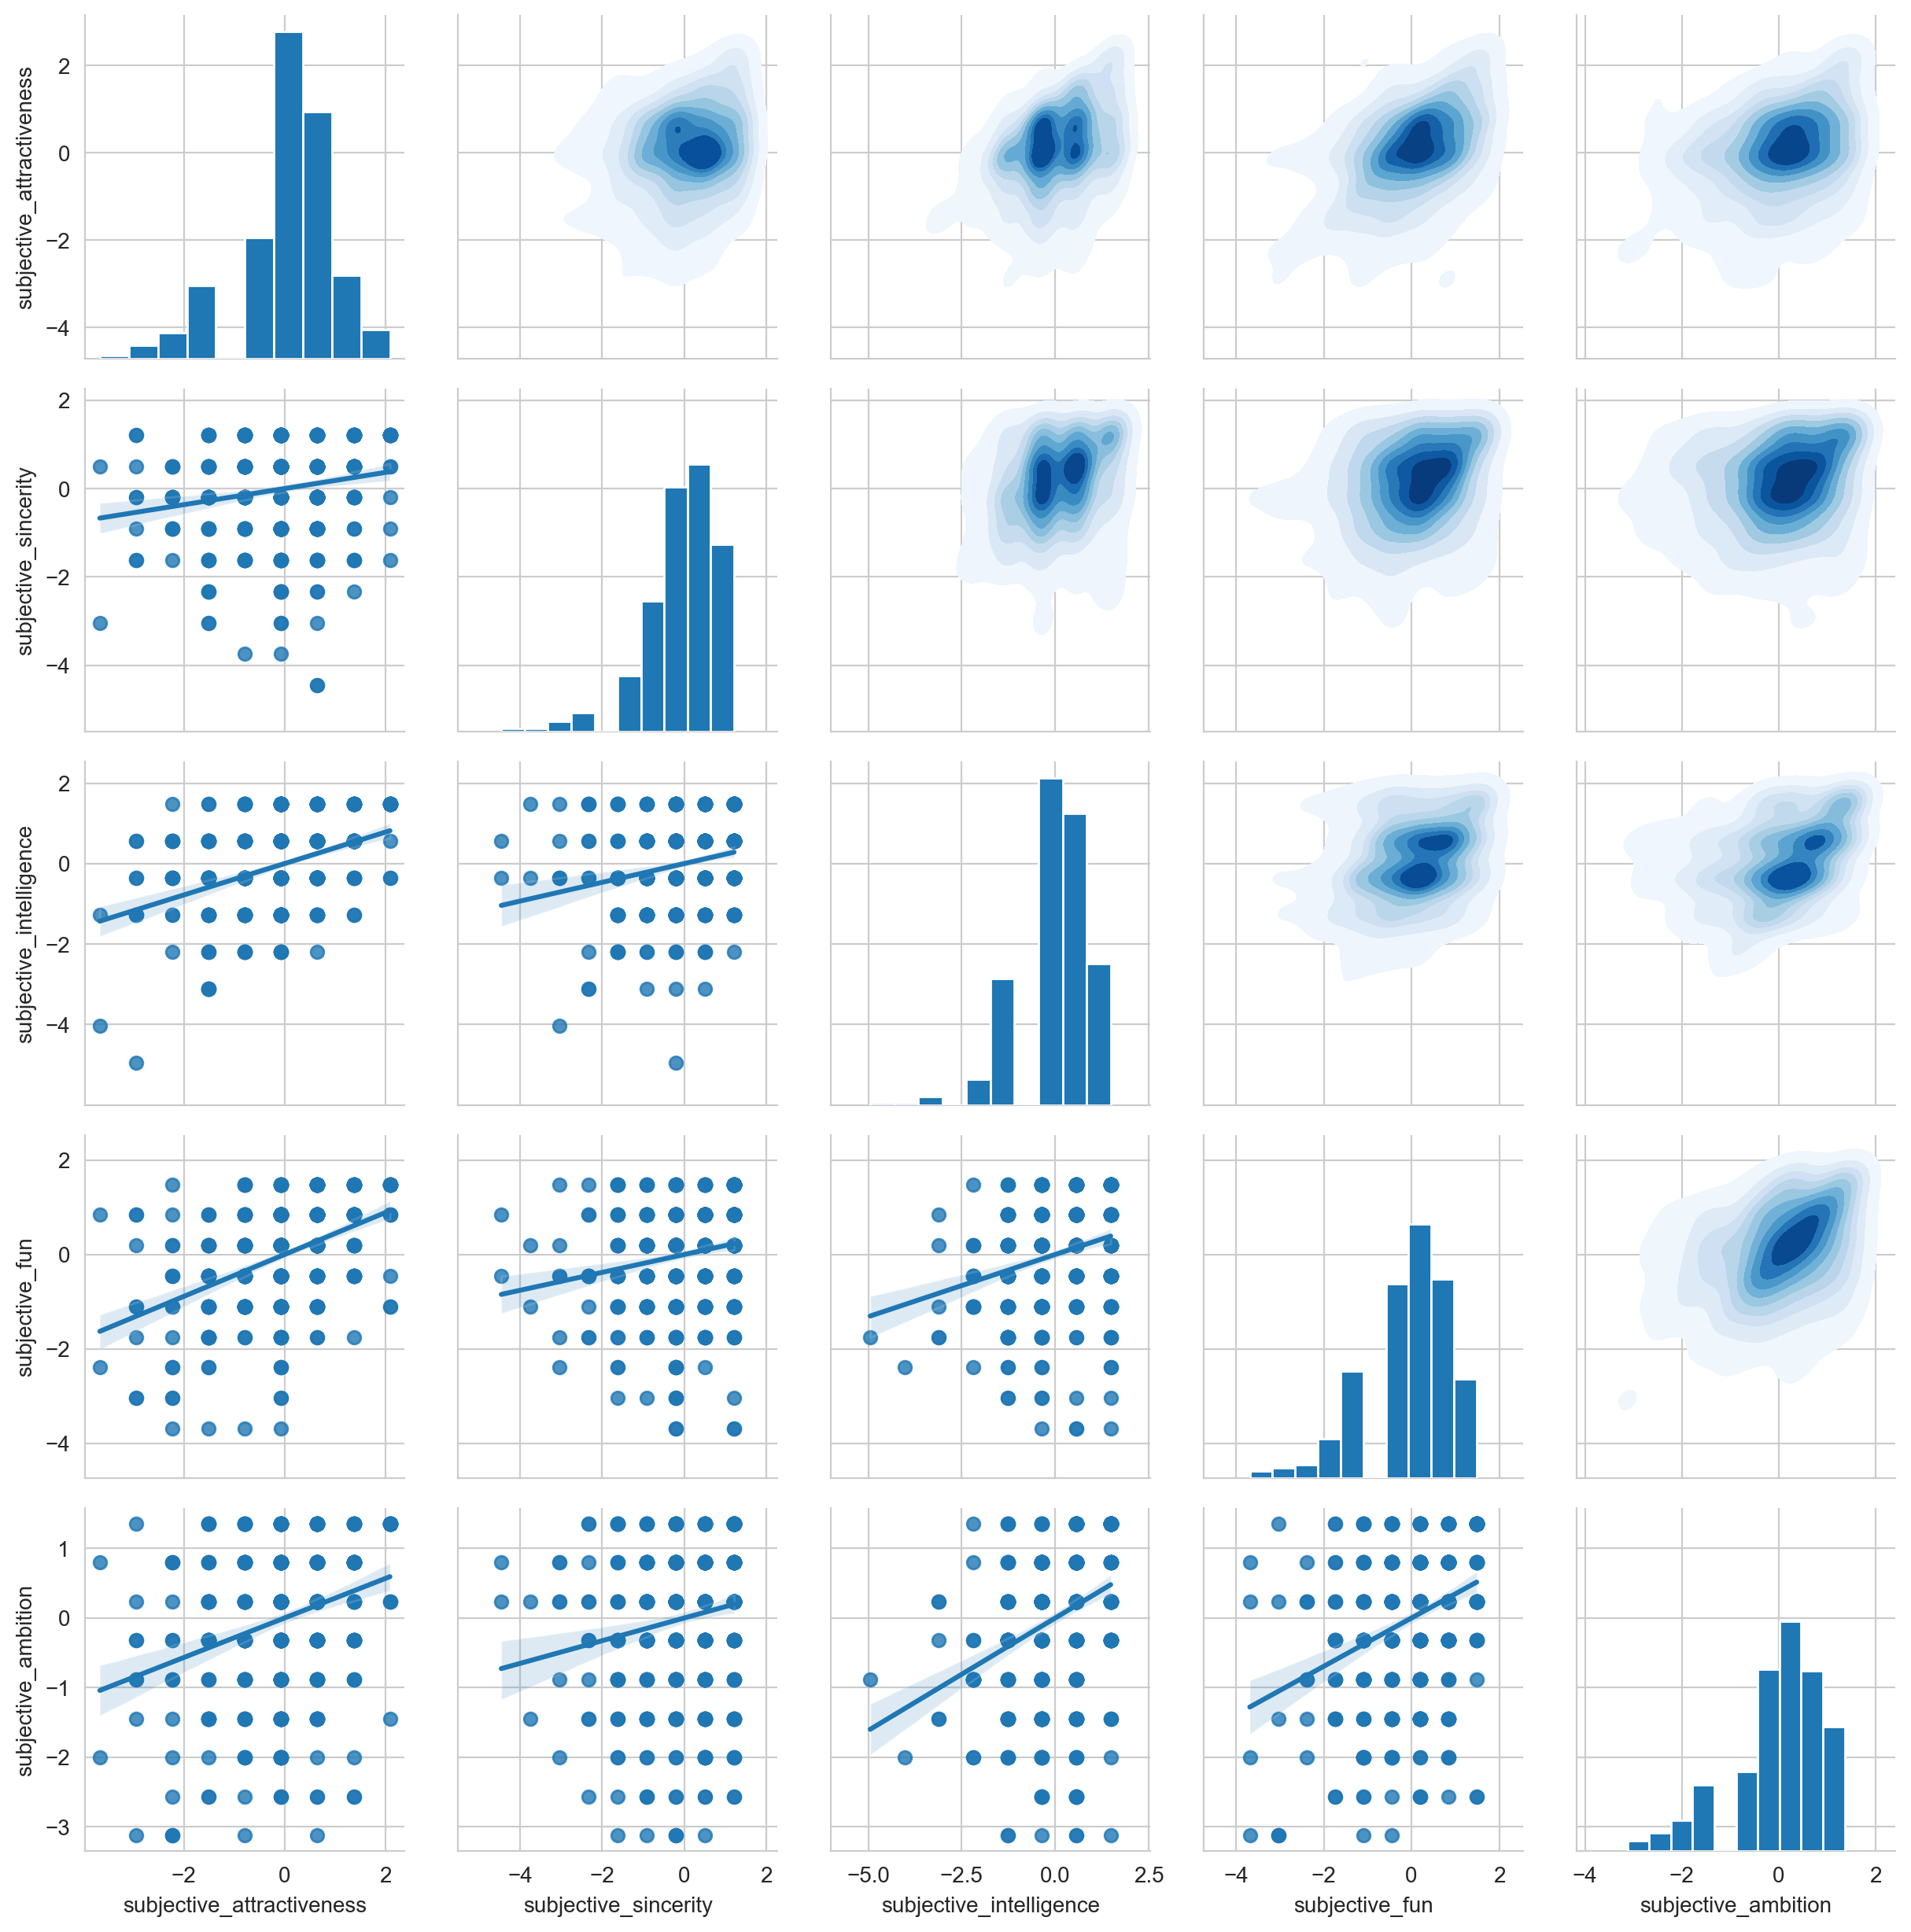

In [17]:
g = sns.PairGrid(sd_subjective_sc_df)
g = g.map_lower(sns.regplot)                                              # Regression plots in the lower triangle
g = g.map_upper(sns.kdeplot, cmap="Blues", fill=True, thresh=0.05)        # KDE plots in upper triangle
g = g.map_diag(plt.hist)                                                  # Histograms along the diagonal
plt.show();

**3.C) Use a heat map to visualize correlation.**

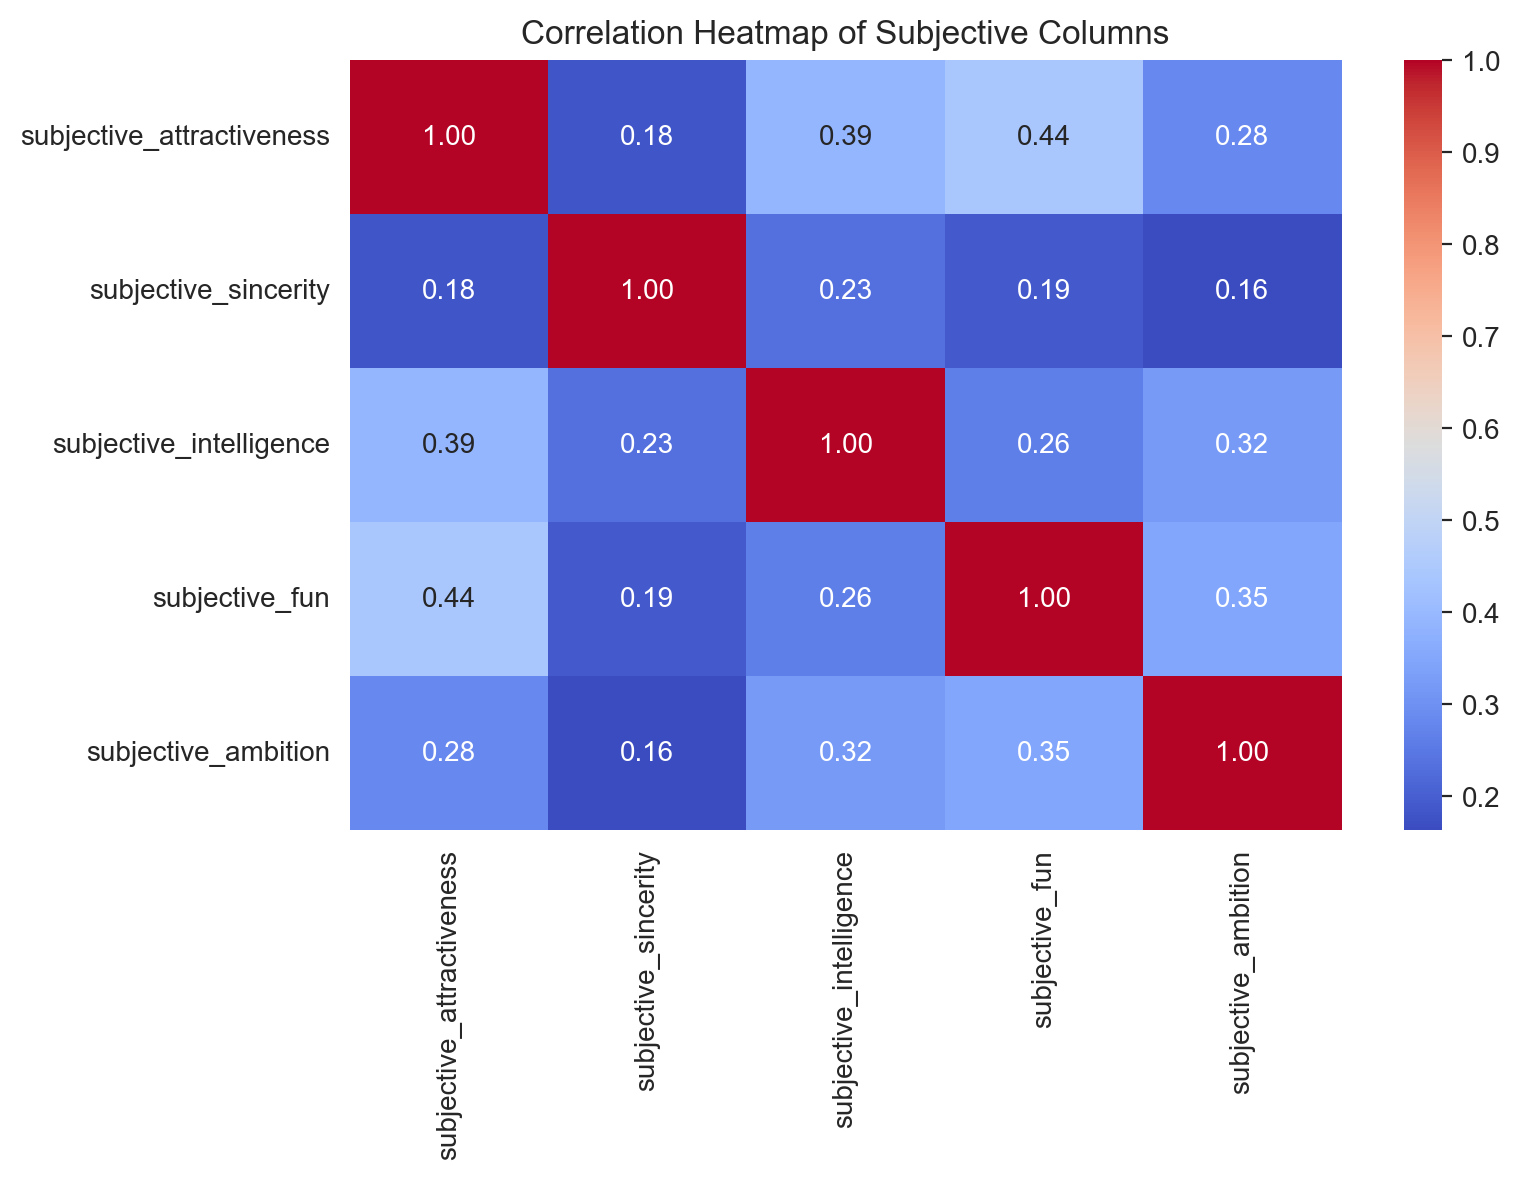

In [19]:
correlation_matrix = sd_subjective_sc_df.corr()
plt.figure(figsize = (8, 5))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f', cbar = True)
plt.title('Correlation Heatmap of Subjective Columns')
plt.show();

---

**Important: Did you ensure the results make sense intuitively?** If not, look at the results again. You should **always** interpret your results and ensure they make sense based on what you expected. If they don’t, investigate why — sometimes your analysis or data are wrong.

> For example, the results show that believing you are attractive and fun are correlated. Would you expect that believing you are intellectual and fun to have a higher or lower correlation? What do the results say?

---


### 4) Visualize some preference columns.

Next, we’ll explore how some preference ratings are correlated. You saw an example — now try it on the `preference_cols` below.

- Find the z scores of each column in `preference_cols`.
- Visualize correlation using PairGrid.
- Visualize correlation using a heat map.
- Do these results make sense intuitively? 

In [21]:
preference_cols = ['like_tvsports', 'like_sports', 'like_museums', 
                   'like_theater', 'like_shopping']
sd_like = sd[preference_cols]

**4.A) Find the z scores of each column in `preference_cols`.**

In [23]:
sc2 = StandardScaler()
sd_preference_sc_df = pd.DataFrame(sc2.fit_transform(sd_like))

**4.B) Visualize correlation using PairGrid.**

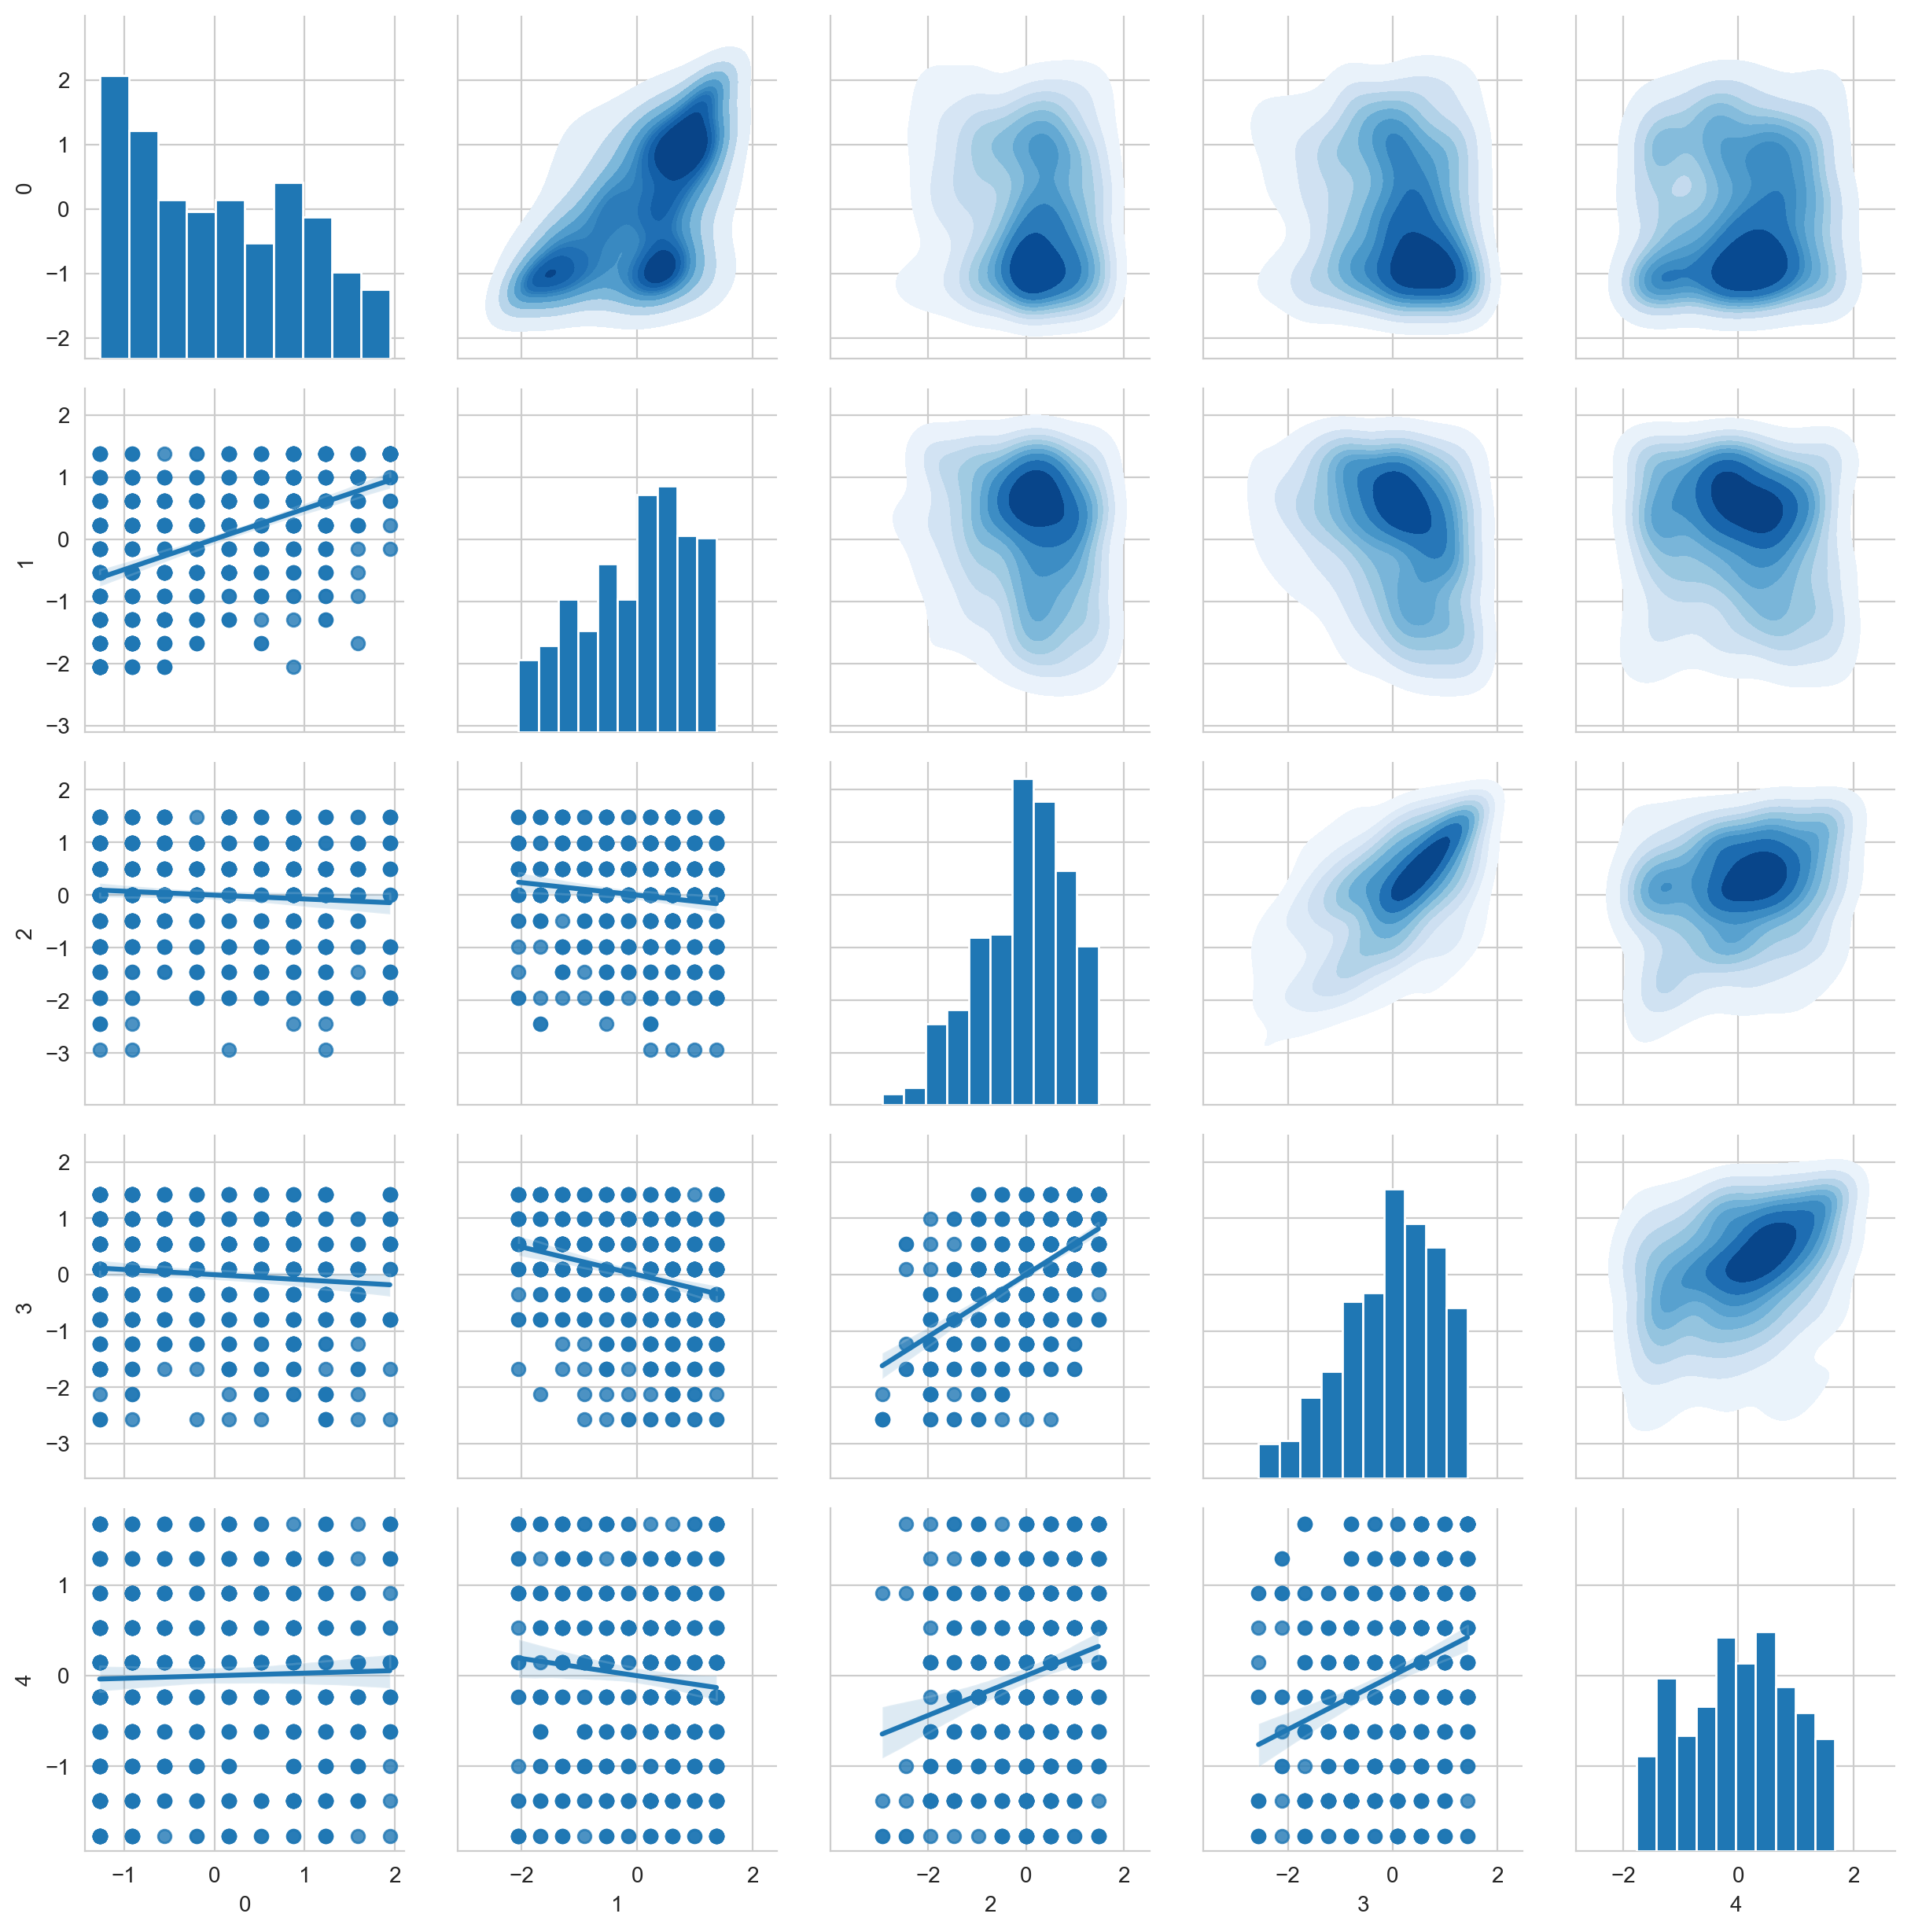

In [25]:
g = sns.PairGrid(sd_preference_sc_df)
g = g.map_lower(sns.regplot)                                              # Regression plots in the lower triangle
g = g.map_upper(sns.kdeplot, cmap="Blues", fill=True, thresh=0.05)        # KDE plots in upper triangle
g = g.map_diag(plt.hist)                                                  # Histograms along the diagonal
plt.show();

**4.C) Visualize correlation using a heat map.**

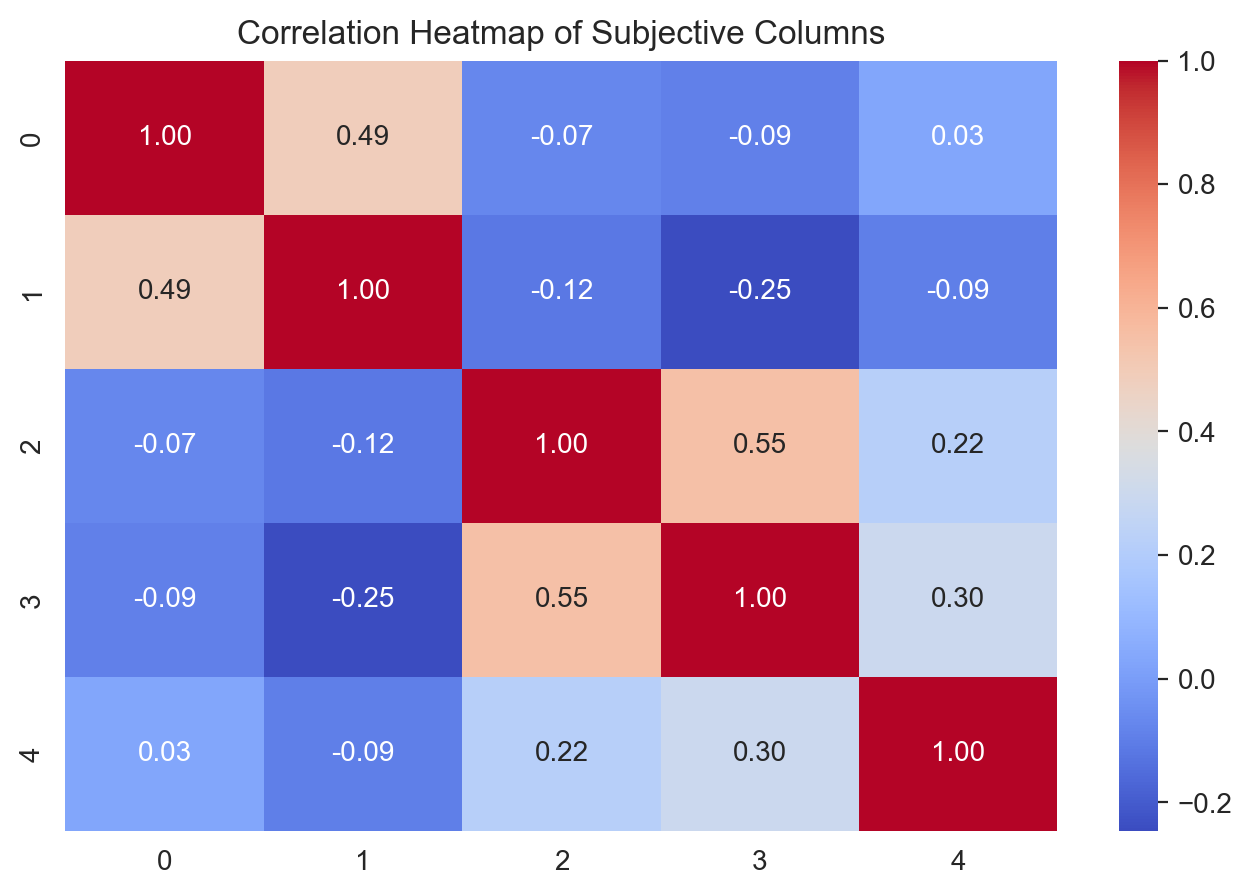

In [27]:
correlation_matrix = sd_preference_sc_df.corr()
plt.figure(figsize = (8, 5))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f', cbar = True)
plt.title('Correlation Heatmap of Subjective Columns')
plt.show();

---

### 5) Example: Fit PCA on the subjective ratings.

In [29]:
subjective_pca = PCA(n_components = 5)
subjective_pca.fit(sd_subjective_sc_df.values)

PCA(n_components=5)

---

**5.A) Look at the weights of the principal components.**

The principal components (or eigenvectors!) are simply the weights or coefficients on the original variables $X$ that transforms them to $Z$.

In [31]:
pc_weights = pd.DataFrame(
    subjective_pca.components_ 
    , columns = sd_subjective_sc_df.columns 
    , index = [f'PC{i+1}' for i in range(subjective_pca.n_components_)]
)

pc_weights

,subjective_attractiveness,subjective_sincerity,subjective_intelligence,subjective_fun,subjective_ambition
PC1,0.501894,0.315290,0.467071,0.483864,0.443187
PC2,-0.218260,0.909060,0.097690,-0.274010,-0.203342
PC3,-0.402024,-0.144386,0.422893,-0.481414,0.637912
PC4,0.348119,-0.213776,0.648420,-0.361047,-0.531328
PC5,0.646263,0.087491,-0.415949,-0.573306,0.270179


---

**5.B) Look at the explained variance values (aka eigenvalues) and the explained variance ratios.**

The eigenvalues are ordered such that the first components have the largest eigenvalues. The values and their normalized equivalent in the explained variance ratio attribute tell you how much of the variance in the original data is encapsulated in the new component variables.

In [33]:
explained_variance = subjective_pca.explained_variance_
explained_variance_ratio = subjective_pca.explained_variance_ratio_

variance_df = pd.DataFrame({
    'Eigenvalue': explained_variance
    , 'Explained Variance Ratio': explained_variance_ratio
    , 'Cumulative Variance Ratio': explained_variance_ratio.cumsum()
}, index = [f'PC{i+1}' for i in range(subjective_pca.n_components_)])

variance_df

,Eigenvalue,Explained Variance Ratio,Cumulative Variance Ratio
PC1,2.160415,0.431286,0.431286
PC2,0.889250,0.177522,0.608808
PC3,0.738209,0.147369,0.756177
PC4,0.722298,0.144193,0.900370
PC5,0.499070,0.099630,1.000000


---

**5.C) Transform the subjective data into the principal component space.**

The `transform()` function in the PCA will create your new component variable matrix.

In [35]:
# Transform
subjective_pca_transformed = subjective_pca.transform(sd_subjective_sc_df.values)
subjective_pca_transformed

array([[-0.673942  , -0.03439955, -0.10382612, -0.35798348, -0.57693667],
       [-1.35044583, -2.02341707, -2.13879048,  1.07112465, -1.64483811],
       [ 0.94967947,  0.27146457, -0.03924025,  0.28967741,  0.18508884],
       ...,
       [-1.27802939, -0.74844718, -0.36801805, -0.31785638,  0.5792599 ],
       [-2.37402987,  0.92246551,  0.44869284,  1.6557433 ,  1.43968236],
       [-1.22960363, -0.72837603, -0.34611708,  0.16632973,  1.41541178]])

This transformed our five-dimensional data set into vectors along its five principal components (with zero loss).
- Using these, we can now reduce the dimensionality of our data while minimizing loss.
- For example, taking only the first three eigenvectors accounts for `0.431 + 0.178 + 0.147 = 75.6%` of the variance.

---

**5.D) PCA-transformed features are not correlated.**

- Keep in mind that each column in the transformed data is no longer correlated.
- Compare this to the exploration above where many columns were correlated.

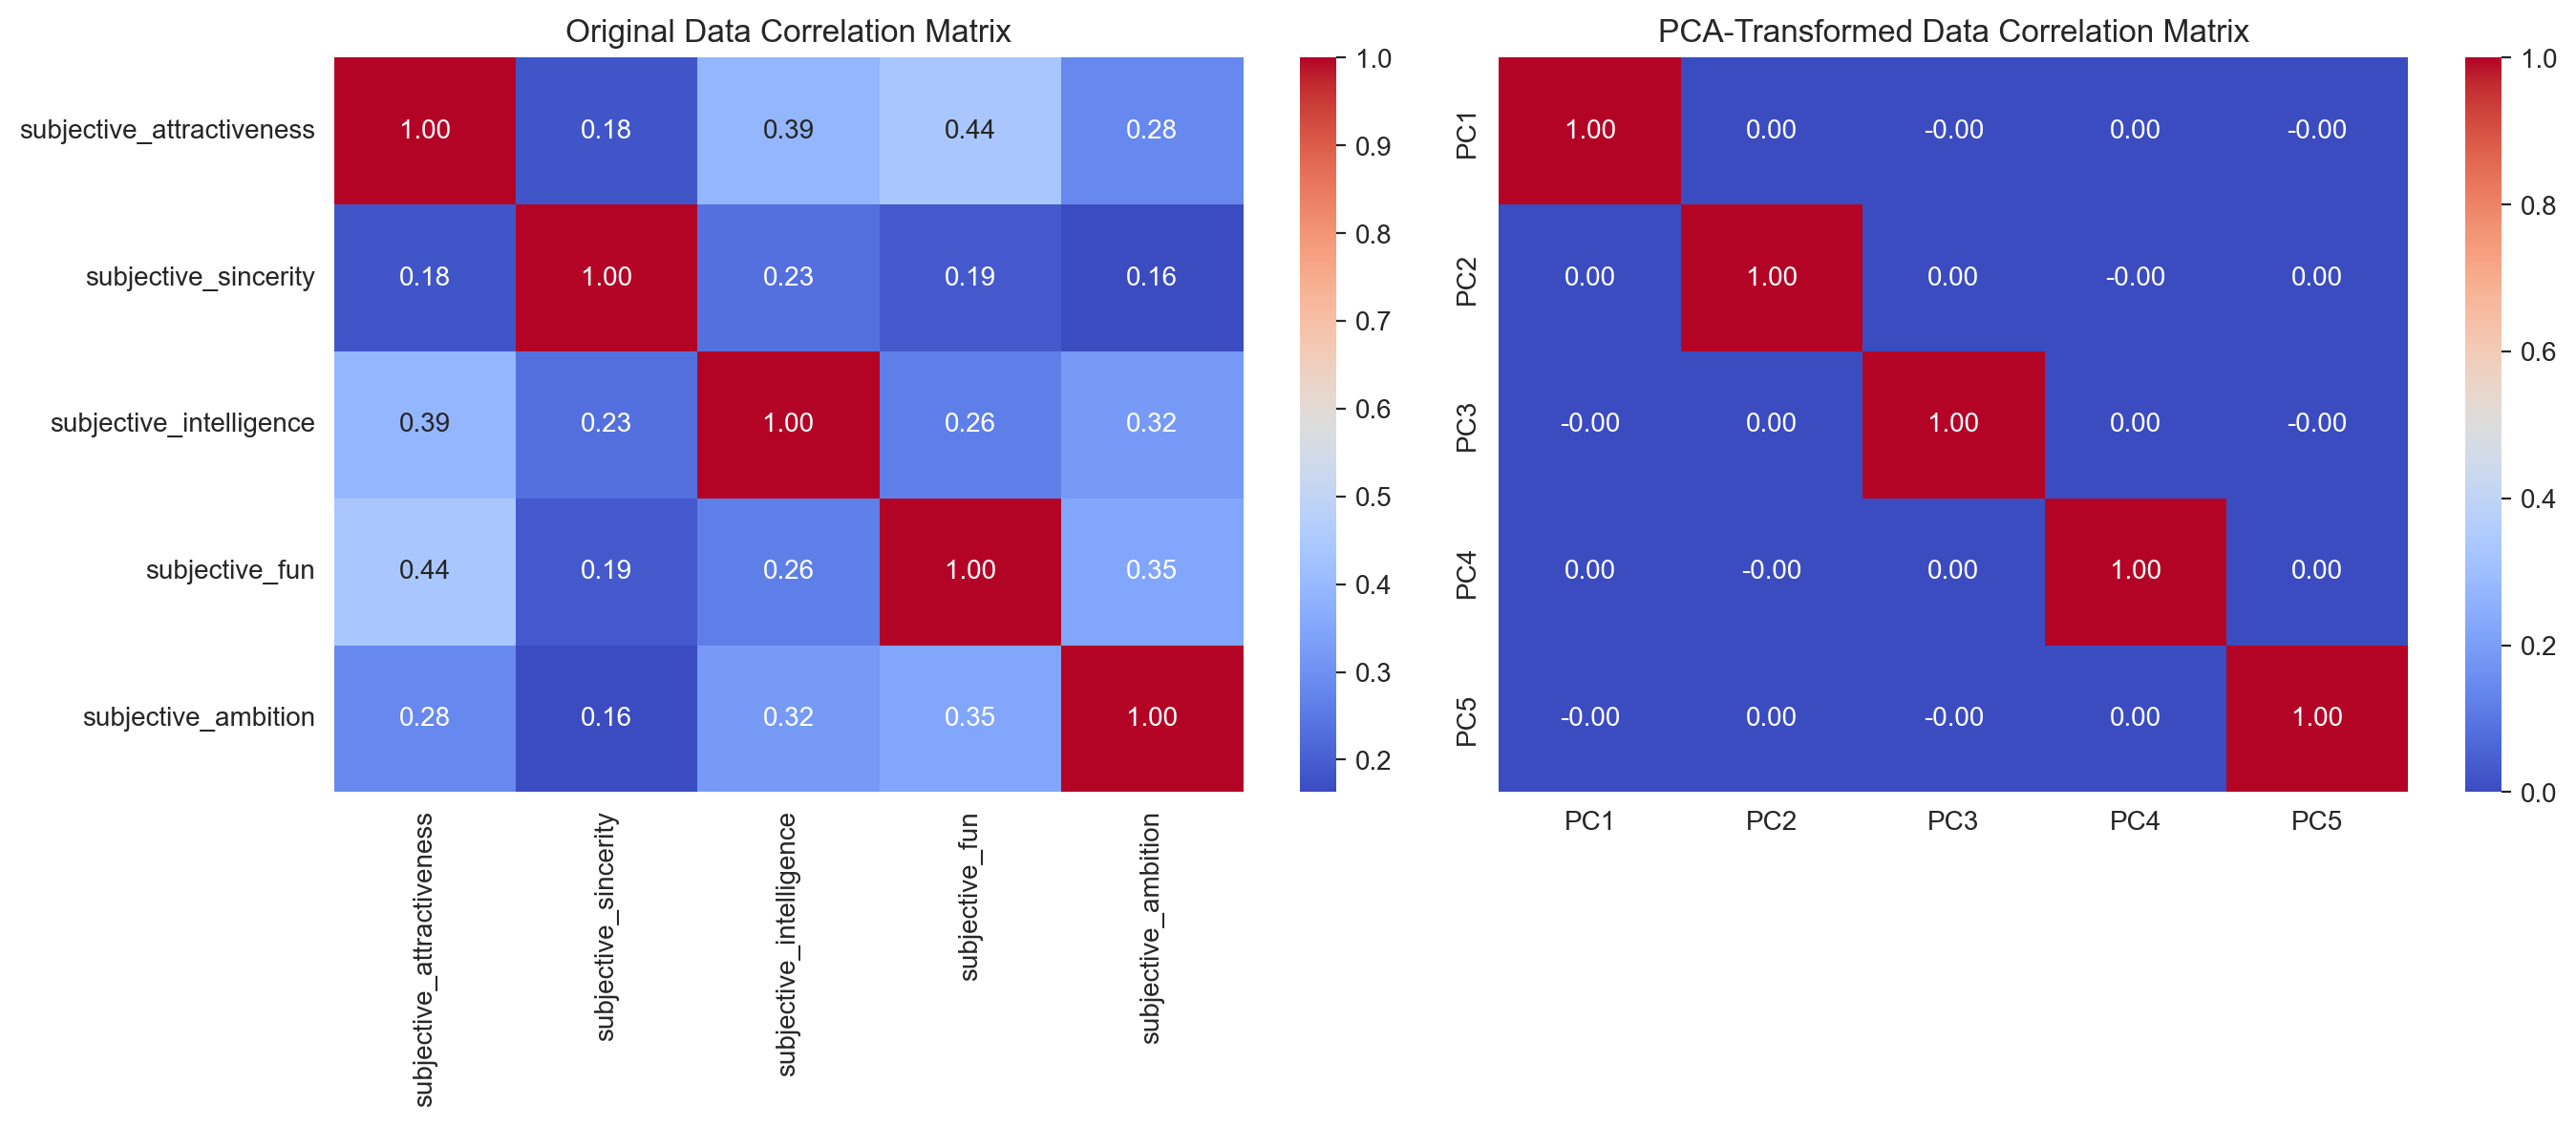

In [38]:
# Original Correlation
original_corr = sd_subjective_sc_df.corr()

# Transformed Correlation
transformed_corr = pd.DataFrame(subjective_pca_transformed, columns=[f'PC{i+1}' for i in range(subjective_pca.n_components_)]).corr()

# Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(original_corr, annot=True, fmt=".2f", cmap="coolwarm", ax=ax[0])
ax[0].set_title("Original Data Correlation Matrix")

sns.heatmap(transformed_corr, annot=True, fmt=".2f", cmap="coolwarm", ax=ax[1])
ax[1].set_title("PCA-Transformed Data Correlation Matrix")

plt.tight_layout()
plt.show();

---

### 6) Optional: How were the data transformed?

To demonstrate how the new principal component matrix is created from the original variable columns and the eigenvector weighting matrix, we'll create the first component (PC1) manually.

**6.A) Pull out the eigenvector for PC1.**

In [40]:
pc1_eigenvector = subjective_pca.components_[0]
pc1_weights = pd.Series(pc1_eigenvector, index=sd_subjective_sc_df.columns)

print("Eigenvector for PC1 (Weights):")
pc1_weights

Eigenvector for PC1 (Weights):


subjective_attractiveness    0.501894
subjective_sincerity         0.315290
subjective_intelligence      0.467071
subjective_fun               0.483864
subjective_ambition          0.443187
dtype: float64

**6.B) Create a DataFrame showing the original values for the subjective variables for `person1`.**

In [42]:
person1_original_values = sd_subjective_sc_df.iloc[0]

person1_df = pd.DataFrame(person1_original_values).T
person1_df.index = ["Person1"]


print("Original Standardized Values for Person1:")
person1_df

Original Standardized Values for Person1:


,subjective_attractiveness,subjective_sincerity,subjective_intelligence,subjective_fun,subjective_ambition
Person1,-0.786472,-0.202716,-0.354194,0.193323,-0.323589


**6.C) Add the eigenvector for PC1: the weights by which to multiply each original variable.**

Recall that each component is a linear combination of the original variables, multiplied by a "weight" defined in the eigenvector of that component.

In [44]:
pc1_weights

subjective_attractiveness    0.501894
subjective_sincerity         0.315290
subjective_intelligence      0.467071
subjective_fun               0.483864
subjective_ambition          0.443187
dtype: float64

In [45]:
person1_df

,subjective_attractiveness,subjective_sincerity,subjective_intelligence,subjective_fun,subjective_ambition
Person1,-0.786472,-0.202716,-0.354194,0.193323,-0.323589


**6.D) Multiply the original variable values by the eigenvector values.**

These are the "pieces" of PC1 that will be added together to create the new value for that person.

In [47]:
person1_df * pc1_weights

,subjective_attractiveness,subjective_sincerity,subjective_intelligence,subjective_fun,subjective_ambition
Person1,-0.394726,-0.063914,-0.165434,0.093542,-0.14341


**6.E) Sum the original values multiplied by the eigenvector weights to get `person1`’s value for PC1.**

In [49]:
(person1_df * pc1_weights).sum().sum()

-0.6739420008503667

---

### 7) Fit PCA on the preference data.

Now that you've seen how it's done, try it yourself!

- Find PCA eigenvalues and eigenvectors for the five `sd_like` columns.
- Transform the original `sd_like` columns into the principal component space.
- Verify that these columns are uncorrelated.

In [51]:
sd_like.head()

,like_tvsports,like_sports,like_museums,like_theater,like_shopping
0,2.0,9.0,1.0,1.0,8.0
1,2.0,3.0,8.0,9.0,3.0
2,8.0,3.0,5.0,7.0,8.0
3,1.0,1.0,6.0,9.0,1.0
4,4.0,7.0,6.0,6.0,8.0


In [52]:
preference_pca = PCA(n_components = 5)
preference_pca.fit(sd_like.values)

PCA(n_components=5)

#### 7.A) Find PCA eigenvalues and eigenvectors for the five `sd_like` columns.

In [54]:
# Eigenvalues:
preference_eigenvalues = preference_pca.explained_variance_

# Eigenvectors
preference_eigenvectors = pd.DataFrame(
    preference_pca.components_
    , columns = sd_like.columns
    , index=[f'PC{i+1}' for i in range(preference_pca.n_components_)]
)


print("PCA Eigenvalues:")
print(preference_eigenvalues)

print("\nPCA Eigenvectors:")
print(preference_eigenvectors)

PCA Eigenvalues:
[11.81445156  8.62194154  4.81476322  3.63861328  1.97420378]

PCA Eigenvectors:
     like_tvsports  like_sports  like_museums  like_theater  like_shopping
PC1       0.627369     0.621670     -0.233043     -0.336857      -0.228369
PC2       0.446111     0.171377      0.361941      0.446306       0.664398
PC3      -0.110636    -0.085301     -0.501806     -0.490124       0.698894
PC4      -0.623387     0.742945      0.207093     -0.019349       0.127118
PC5       0.080875    -0.157835      0.721105     -0.668388       0.042562


#### 7.B) Transform the original `sd_like` columns into the principal component space.

In [56]:
# Transform
sd_like_pca_transformed = preference_pca.transform(sd_like.values)

sd_like_pca_df = pd.DataFrame(
    sd_like_pca_transformed, 
    columns=[f'PC{i+1}' for i in range(preference_pca.n_components_)]
)


print("PCA-Transformed Features:")
print(sd_like_pca_df.head())

PCA-Transformed Features:
        PC1       PC2       PC3       PC4       PC5
0  2.813509 -3.852697  7.562375  2.705369 -0.971477
1 -4.100823 -2.098915 -2.853924 -1.093037 -0.536650
2 -0.105608  1.921308  2.462398 -4.780351 -0.665129
3 -5.048710 -4.940457 -2.966862 -2.623962 -1.829191
4 -0.024590  0.738005  2.552055  0.911421 -0.230473


#### 7.C) Verify that these columns are uncorrelated.

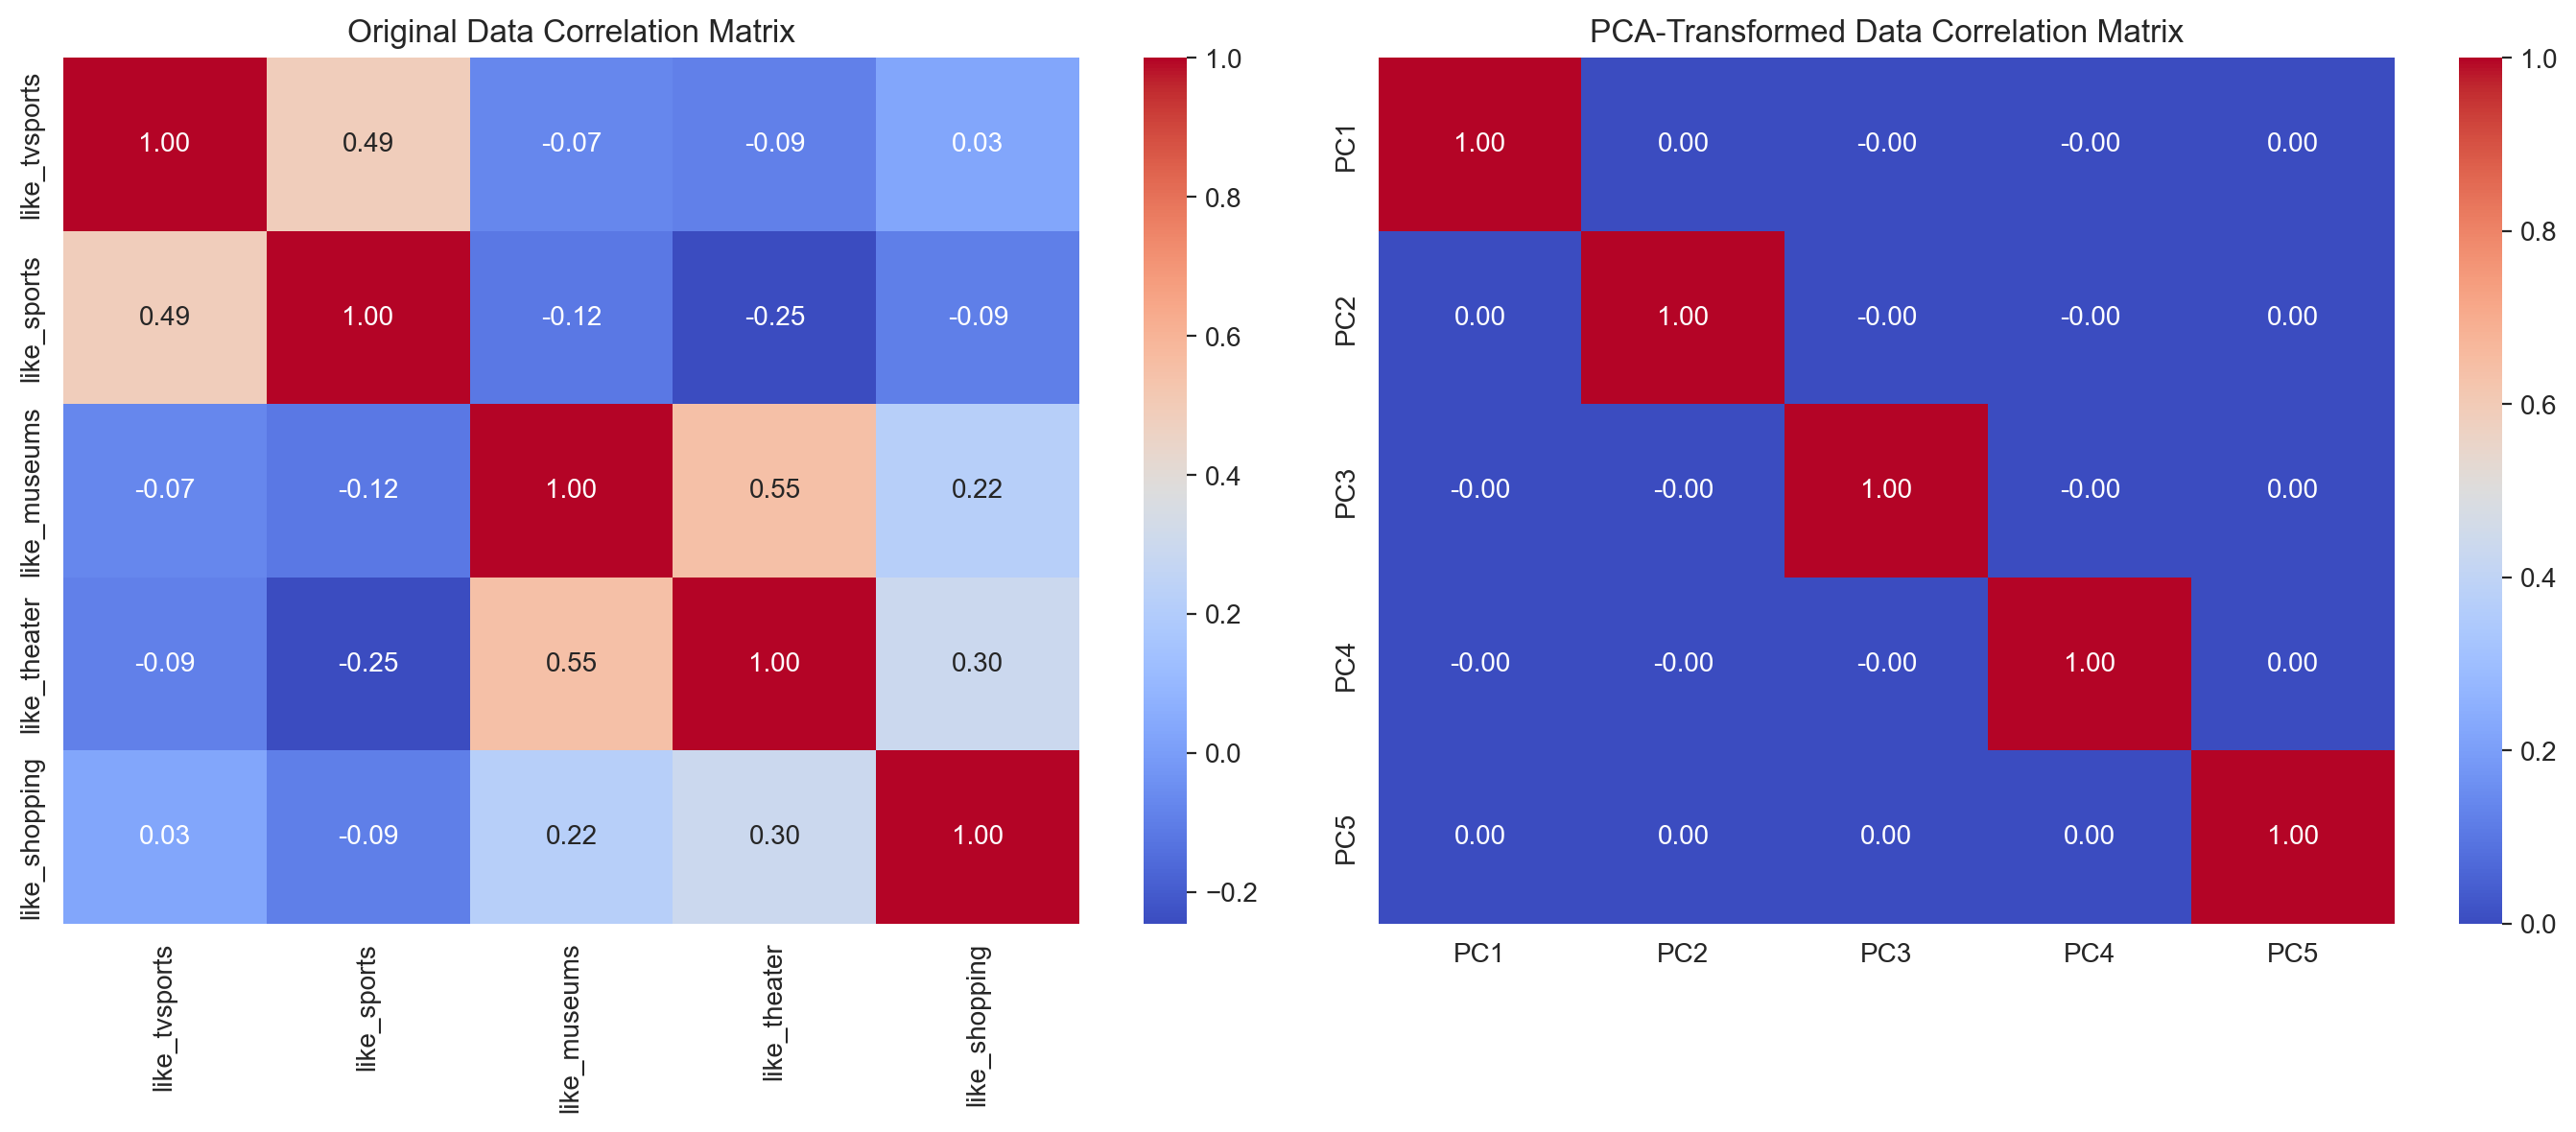

In [58]:
# Original Correlation
original_corr = sd_like.corr()

# Transformed Correlation
transformed_corr = pd.DataFrame(sd_like_pca_df, columns=[f'PC{i+1}' for i in range(subjective_pca.n_components_)]).corr()

# Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(original_corr, annot=True, fmt=".2f", cmap="coolwarm", ax=ax[0])
ax[0].set_title("Original Data Correlation Matrix")

sns.heatmap(transformed_corr, annot=True, fmt=".2f", cmap="coolwarm", ax=ax[1])
ax[1].set_title("PCA-Transformed Data Correlation Matrix")

plt.tight_layout()
plt.show();

---

### 8) Use PCA for dimensionality reduction.

Using linear regression, let's predict whether or not a user likes reading.

**The key question:** Can we get the same prediction accuracy using only the first three principal components as features versus using all five original values as features?

In [60]:
reading = sd['like_reading'].values

**8.A) Linear regression cross-validated on original variables (`sd_like.values`).**

- What is the mean cross-validation score?
- Keep in mind that linear regression uses $R^2$ for score, so one is the ideal score.

In [62]:
lr = LinearRegression()                 # Instantiate Linear Regression

cv_scores = cross_val_score(lr
                            , sd_like.values
                            , reading
                            , cv = 5
                            , scoring = 'r2'
                           )


mean_cv_score = cv_scores.mean()

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score (R^2):", mean_cv_score)

Cross-validation scores: [-0.00452896  0.13167438  0.02237835  0.17929338  0.13084444]
Mean cross-validation score (R^2): 0.09193231749299213


**8.B) Linear regression on the first principal component.**

- What is the mean cross-validation score?

In [64]:
pc1 = sd_like_pca_df['PC1'].values

cv_scores_pc1 = cross_val_score(lr
                                , pc1.reshape(-1, 1)
                                , reading
                                , cv = 5
                                , scoring='r2'
                               )

mean_cv_score_pc1 = cv_scores_pc1.mean()

print("Cross-validation scores for PC1:", cv_scores_pc1)
print("Mean cross-validation score for PC1 (R^2):", mean_cv_score_pc1)

Cross-validation scores for PC1: [-0.05826745  0.0942921  -0.0531123   0.05570881  0.03459837]
Mean cross-validation score for PC1 (R^2): 0.01464390742690136


**8.C) Linear regression on first three principal components.**

- What is the mean cross-validation score?

In [66]:
pc123 = sd_like_pca_df[['PC1', 'PC2', 'PC3']].values

cv_scores_pc123 = cross_val_score(lr
                                  , pc123
                                  , reading
                                  , cv = 5
                                  , scoring = 'r2')


mean_cv_score_pc123 = cv_scores_pc123.mean()

print("Cross-validation scores for the first three principal components:", cv_scores_pc123)
print("Mean cross-validation score for the first three principal components (R^2):", mean_cv_score_pc123)

Cross-validation scores for the first three principal components: [-0.05205082  0.13209781  0.04510342  0.18249276  0.10163748]
Mean cross-validation score for the first three principal components (R^2): 0.0818561298757435


---

**Check yourself**. The mean cross-validation score should be nearly the same for the first three principal components as it was on the original five-component data.

In [68]:
cv_scores_original = cross_val_score(lr
                                  , sd_preference_sc_df
                                  , reading
                                  , cv = 5
                                  , scoring = 'r2')


mean_cv_score_original = cv_scores_original.mean()

print("Cross-validation scores original components:", cv_scores_original)
print("Mean cross-validation score for original components (R^2):", mean_cv_score_original)

Cross-validation scores original components: [-0.00452896  0.13167438  0.02237835  0.17929338  0.13084444]
Mean cross-validation score for original components (R^2): 0.09193231749299227
